### Variant stabilization method to detect highly variable genes in Yeast

In [1]:
## Load the necessary libraies
library("ggplot2")
library("sctransform")
library("wordcloud")
library("corrplot")

Loading required package: RColorBrewer

corrplot 0.90 loaded



###  Single-cell RNA-seq (S. cerevicea, @log phase)

In [2]:
pbmc_data=read.csv("../Data/GSE144820_RAW/GSM4297055_processed_counts_glu_12h.csv", row.names = 1)

In [3]:
gene_attr <- data.frame(mean = rowMeans(pbmc_data), detection_rate = rowMeans(pbmc_data > 
    0), var = apply(pbmc_data, 1, var))
gene_attr$log_mean <- log10(gene_attr$mean)
gene_attr$log_var <- log10(gene_attr$var)
rownames(gene_attr) <- rownames(pbmc_data)
cell_attr <- data.frame(n_umi = colSums(pbmc_data), n_gene = colSums(pbmc_data > 
    0))
rownames(cell_attr) <- colnames(pbmc_data)

Warning message:
“Removed 1330 rows containing non-finite values (stat_density2d).”


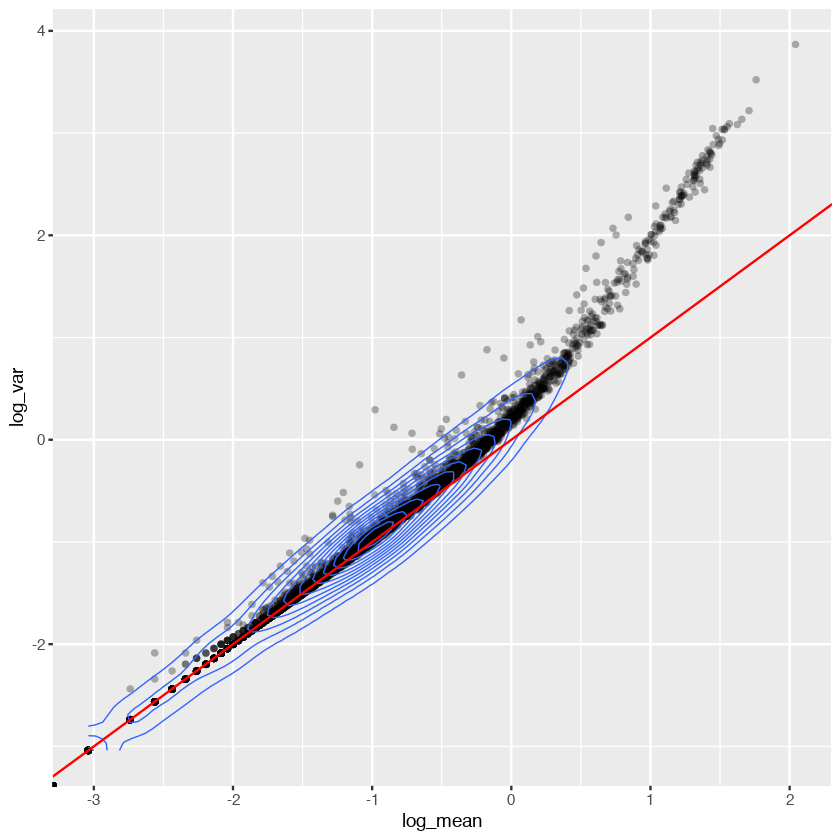

In [4]:
ggplot(gene_attr, aes(log_mean, log_var)) + geom_point(alpha = 0.3, shape = 16) + 
    geom_density_2d(size = 0.3) + geom_abline(intercept = 0, slope = 1, color = "red")


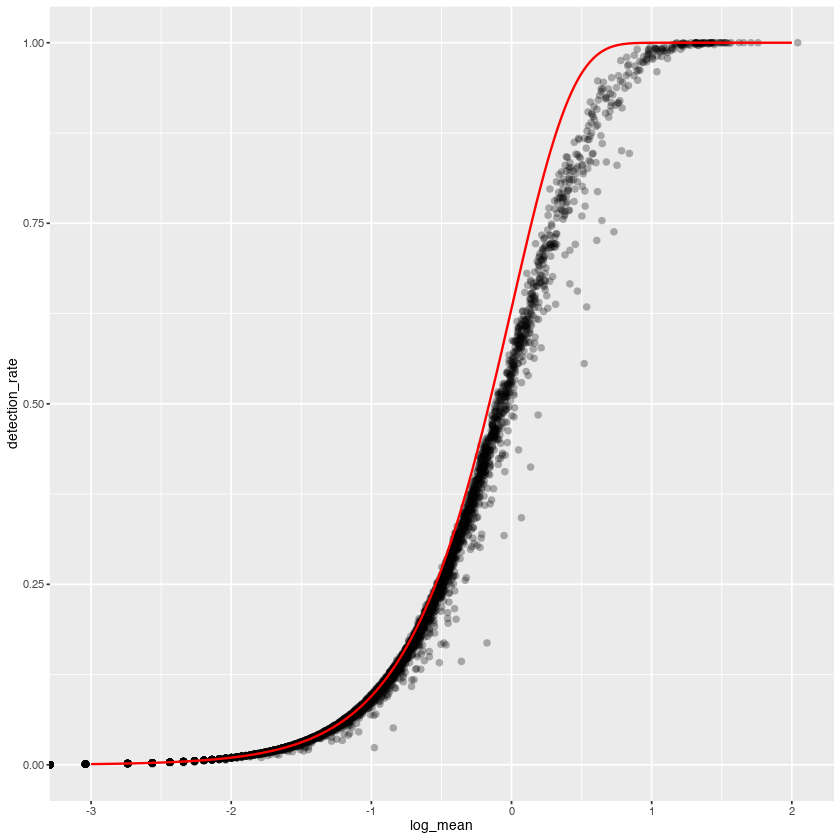

In [5]:
# add the expected detection rate under Poisson model
x = seq(from = -3, to = 2, length.out = 1000)
poisson_model <- data.frame(log_mean = x, detection_rate = 1 - dpois(0, lambda = 10^x))
ggplot(gene_attr, aes(log_mean, detection_rate)) + geom_point(alpha = 0.3, shape = 16) + 
    geom_line(data = poisson_model, color = "red") + theme_gray(base_size = 8)

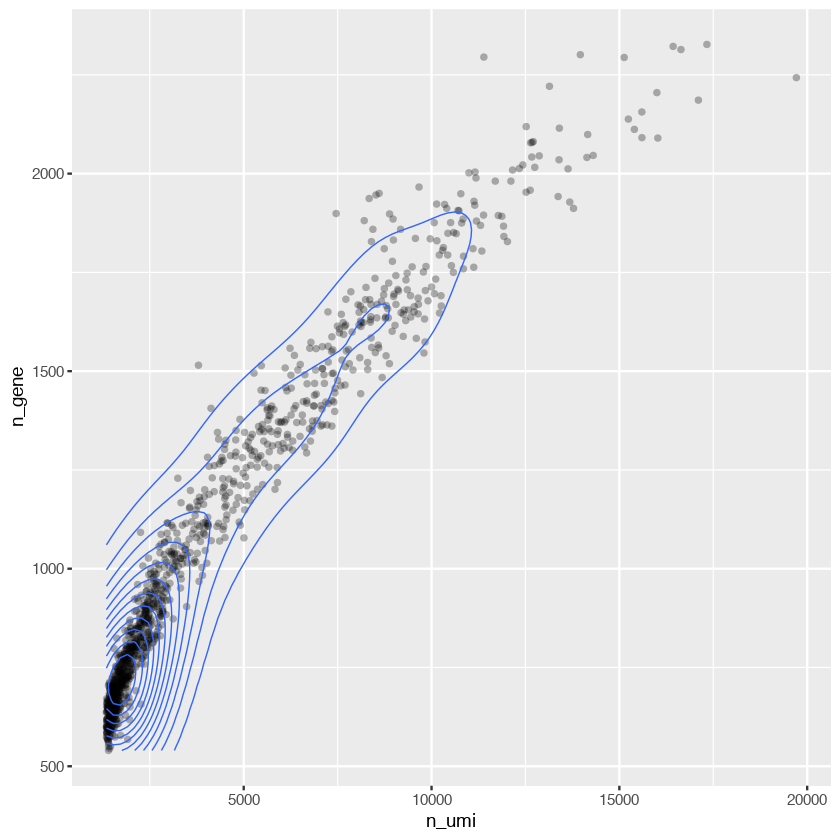

In [6]:
ggplot(cell_attr, aes(n_umi, n_gene)) + geom_point(alpha = 0.3, shape = 16) + geom_density_2d(size = 0.3)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 5255 by 1096

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1096 cells

Found 98 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 5255 genes

Calculating gene attributes

Wall clock passed: Time difference of 15.20545 secs



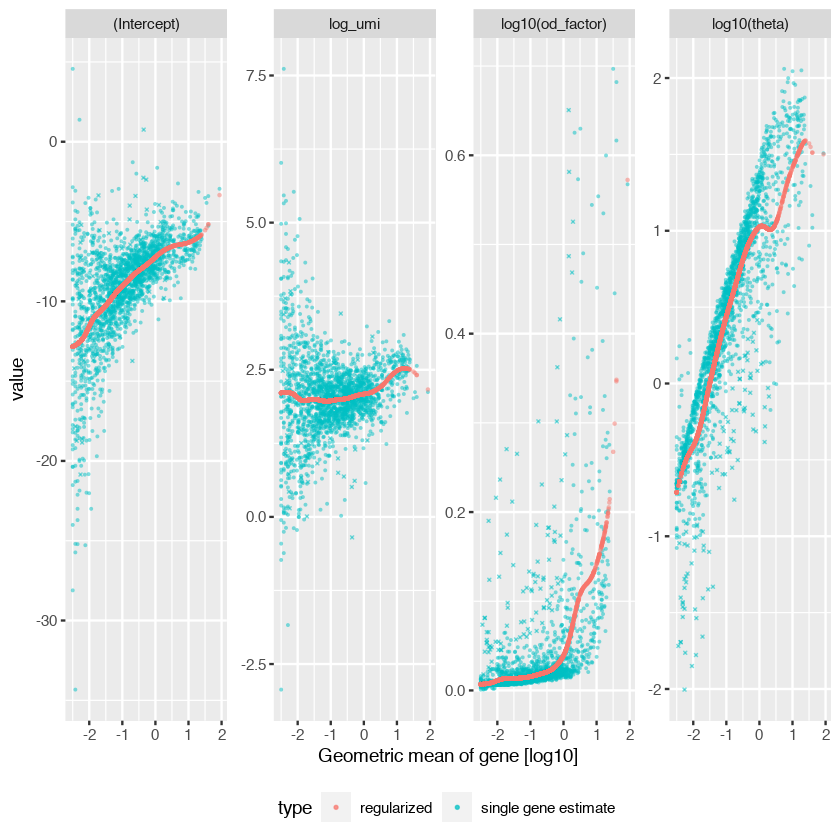

In [7]:
set.seed(44)
options(warn = -1)
pbmc_data=as.matrix(pbmc_data)
vst_out <- sctransform::vst(pbmc_data, latent_var = c("log_umi"), return_gene_attr = TRUE, 
    return_cell_attr = TRUE, verbosity = 1)
#> Calculating cell attributes from input UMI matrix: log_umi
#> Variance stabilizing transformation of count matrix of size 12572 by 2700
#> Model formula is y ~ log_umi
#> Get Negative Binomial regression parameters per gene
#> Using 2000 genes, 2700 cells
#> Found 120 outliers - those will be ignored in fitting/regularization step
#> Second step: Get residuals using fitted parameters for 12572 genes
#> Calculating gene attributes
#> Wall clock passed: Time difference of 17.82073 secs
sctransform::plot_model_pars(vst_out, show_theta = TRUE)

In [9]:
S_cer_log_phase=vst_out$gene_attr

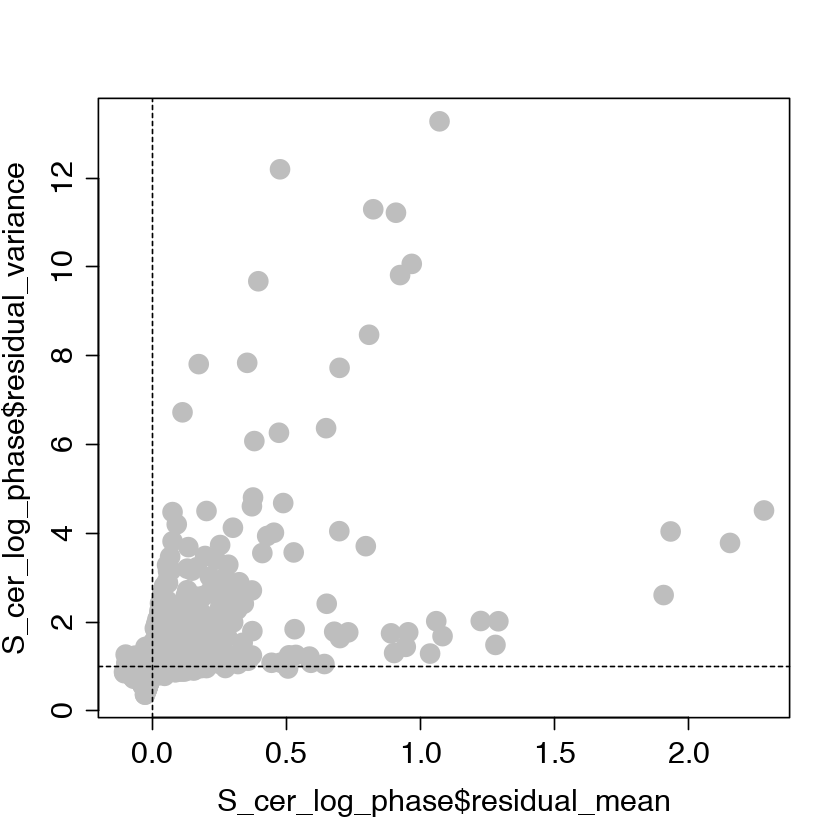

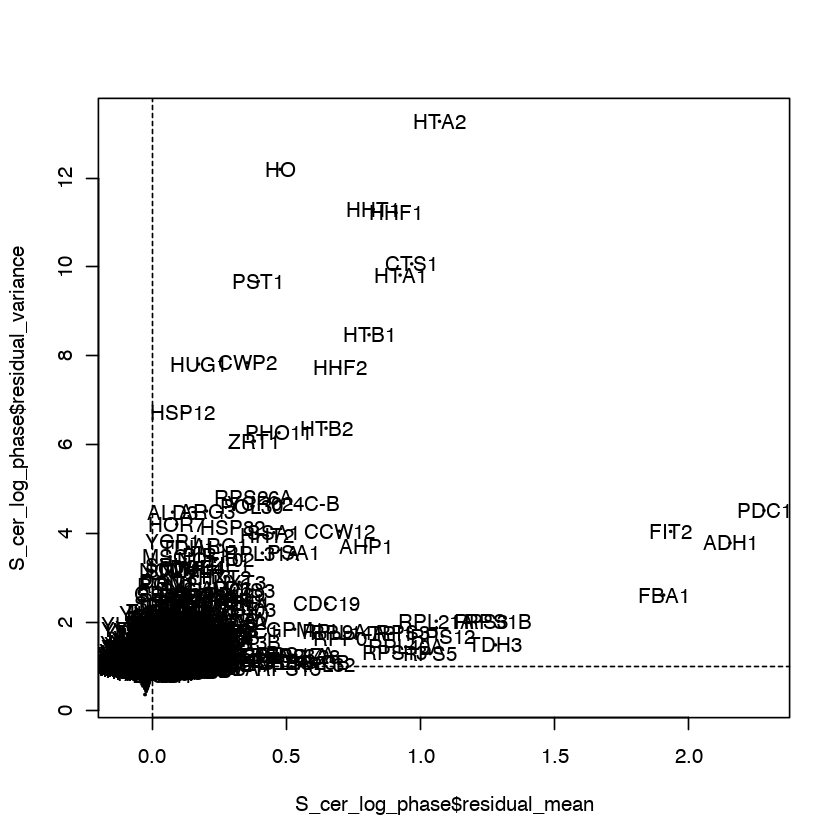

In [10]:
### stabilized_variance
plot(S_cer_log_phase$residual_mean, S_cer_log_phase$residual_variance, cex=2, pch=19, col="gray", cex.lab=1.5, cex.axis=1.5)
abline(v=0, lty=2)
abline(h=1, lty=2)

### Stabilized_variance_with_names (@lag_3h)
plot(S_cer_log_phase$residual_mean, S_cer_log_phase$residual_variance, cex=0.1)
abline(v=0, lty=2)
abline(h=1, lty=2)
index_outlier=which(S_cer_log_phase$residual_mean >0, S_cer_log_phase$residual_variance > 4)
text(S_cer_log_phase$residual_mean[index_outlier], S_cer_log_phase$residual_variance[index_outlier], rownames(S_cer_log_phase)[index_outlier])


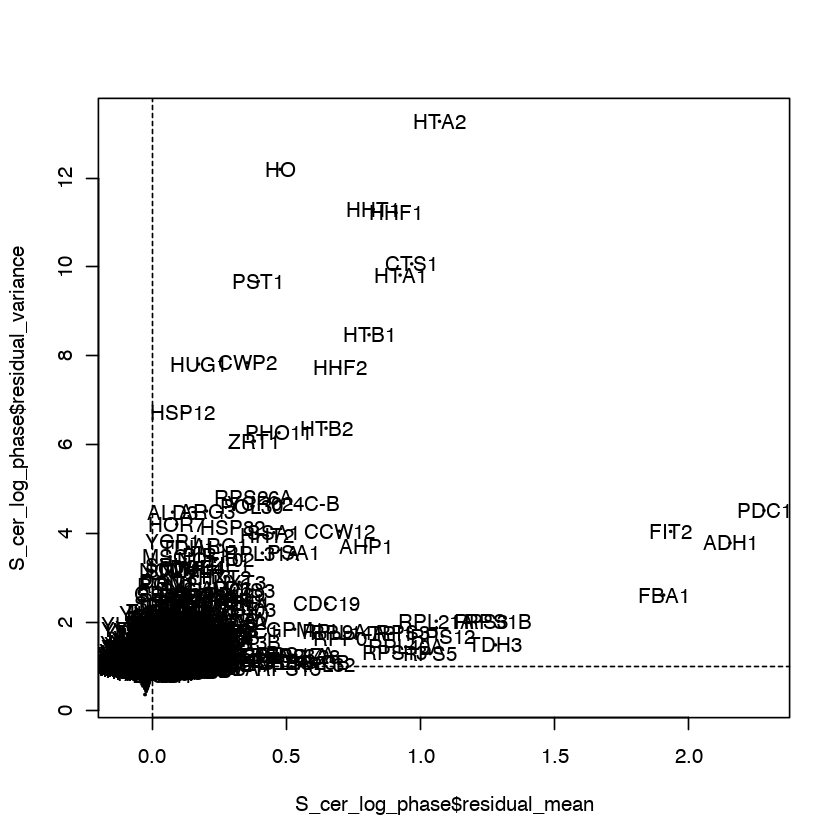

In [11]:
#pdf("Stabilized_variance_with_names_lag_3h.pdf")
plot(S_cer_log_phase$residual_mean, S_cer_log_phase$residual_variance, cex=0.1)
abline(v=0, lty=2)
abline(h=1, lty=2)
index_outlier=which(S_cer_log_phase$residual_mean >0, S_cer_log_phase$residual_variance > 4)
text(S_cer_log_phase$residual_mean[index_outlier], S_cer_log_phase$residual_variance[index_outlier], rownames(S_cer_log_phase)[index_outlier])
#dev.off()

In [12]:
### Gene names for GO enrichment analysis
t(t(rownames(S_cer_log_phase[which(S_cer_log_phase$residual_variance > 3),])))

HO
RPL31A
PSA1
PST1
HTB1
HTA1
ADH1
ARG1
FIT2
FIT3
ZRT1


In [13]:
NFR=read.csv("NFR.csv", stringsAsFactors = FALSE)

In [14]:
NFR=NFR[match(rownames(S_cer_log_phase), NFR$symbol),]
NFR=NFR[,-c(1,2)]

In [15]:
MAT=cbind(S_cer_log_phase$residual_mean, S_cer_log_phase$residual_variance, NFR)
colnames(MAT)[1:2]=c("residual_mean", "residual_var")
MAT=as.data.frame(MAT)

###  Single-cell RNA-seq (S. cerevicea, @lag phase)

In [17]:
pbmc_data=read.csv("../Data/GSE144820_RAW/GSM4297056_processed_counts_inlag_1h.csv", row.names = 1)

In [18]:
gene_attr <- data.frame(mean = rowMeans(pbmc_data), detection_rate = rowMeans(pbmc_data > 
    0), var = apply(pbmc_data, 1, var))
gene_attr$log_mean <- log10(gene_attr$mean)
gene_attr$log_var <- log10(gene_attr$var)
rownames(gene_attr) <- rownames(pbmc_data)
cell_attr <- data.frame(n_umi = colSums(pbmc_data), n_gene = colSums(pbmc_data > 
    0))
rownames(cell_attr) <- colnames(pbmc_data)

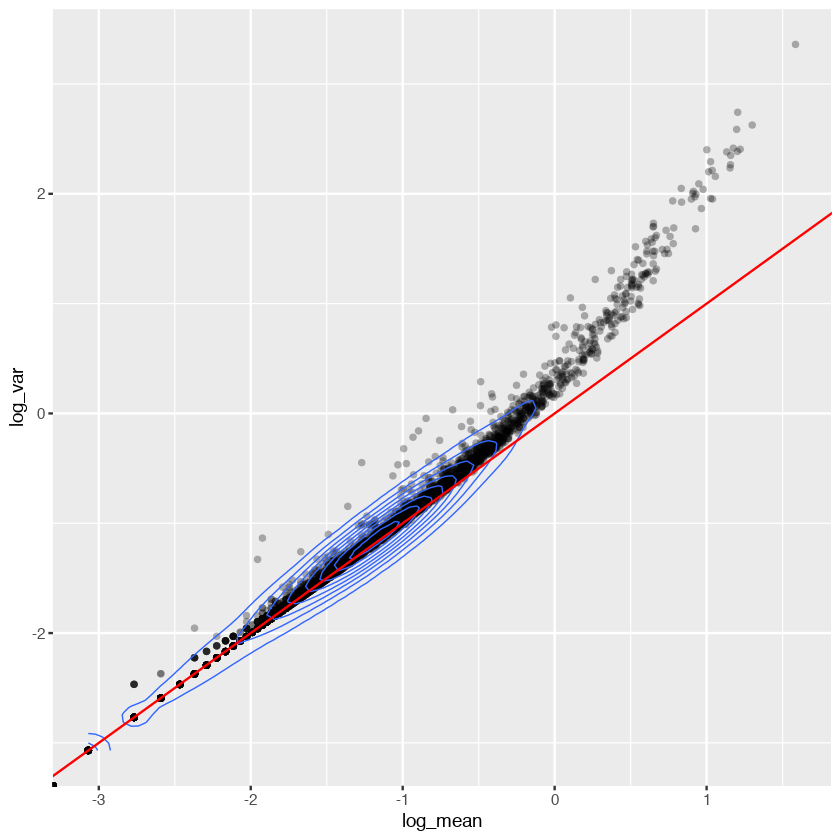

In [19]:
ggplot(gene_attr, aes(log_mean, log_var)) + geom_point(alpha = 0.3, shape = 16) + 
    geom_density_2d(size = 0.3) + geom_abline(intercept = 0, slope = 1, color = "red")

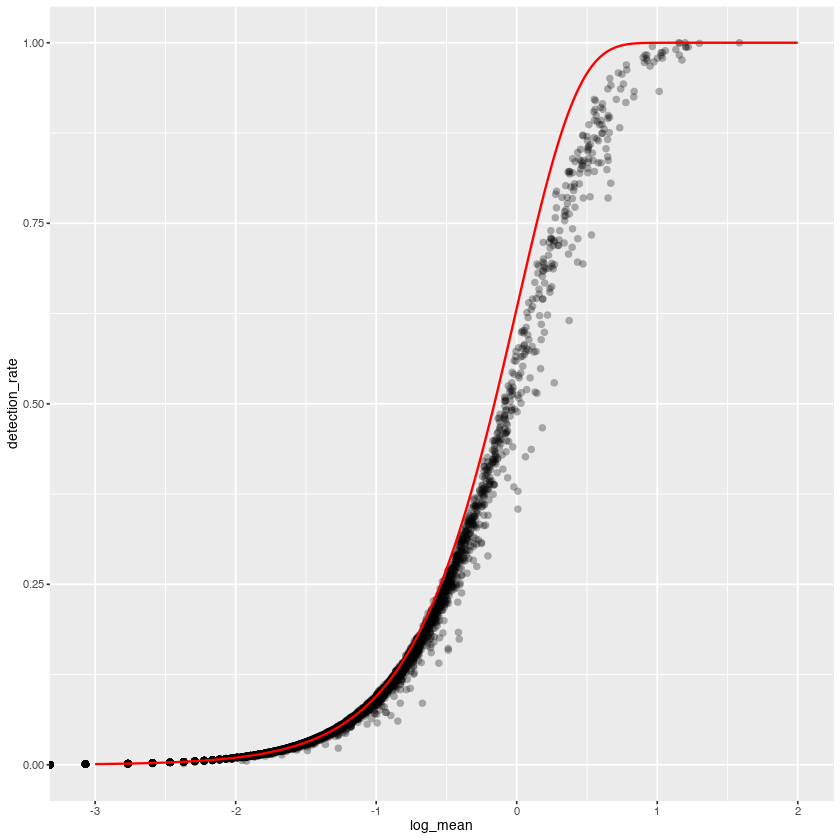

In [20]:
# add the expected detection rate under Poisson model
x = seq(from = -3, to = 2, length.out = 1000)
poisson_model <- data.frame(log_mean = x, detection_rate = 1 - dpois(0, lambda = 10^x))
ggplot(gene_attr, aes(log_mean, detection_rate)) + geom_point(alpha = 0.3, shape = 16) + 
    geom_line(data = poisson_model, color = "red") + theme_gray(base_size = 8)

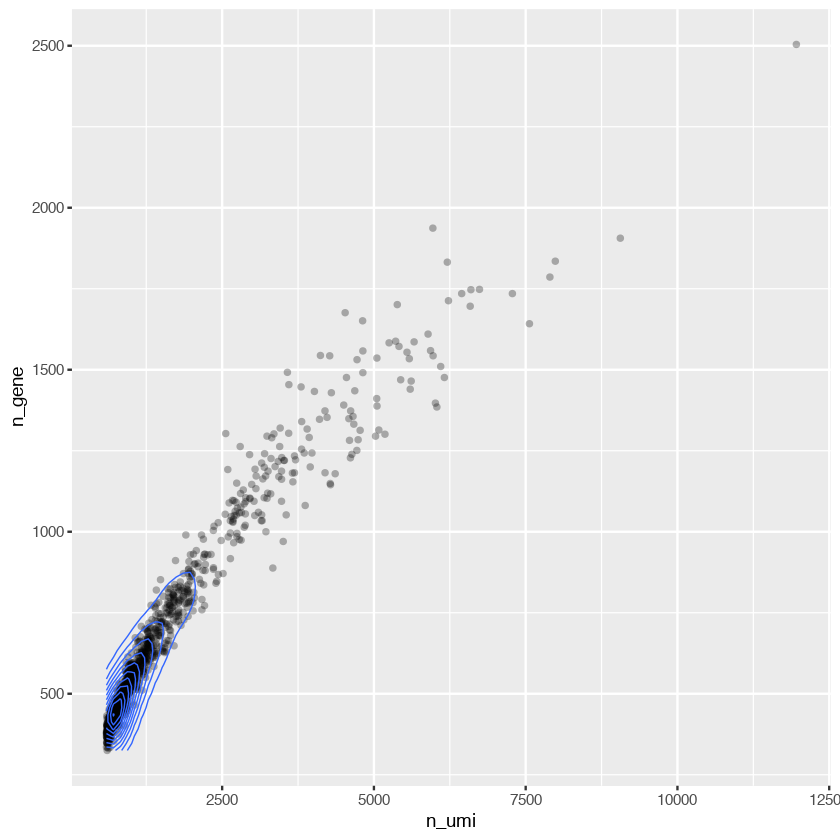

In [21]:
ggplot(cell_attr, aes(n_umi, n_gene)) + geom_point(alpha = 0.3, shape = 16) + geom_density_2d(size = 0.3)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 5289 by 1172

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1172 cells

Found 88 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 5289 genes

Calculating gene attributes

Wall clock passed: Time difference of 21.49089 secs



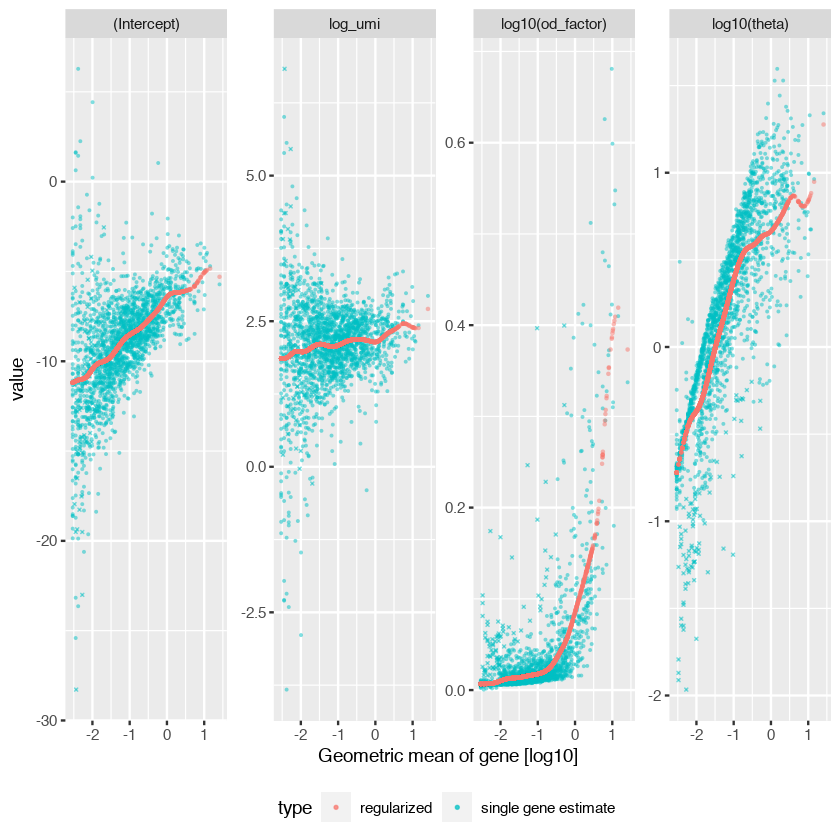

In [22]:
set.seed(44)
pbmc_data=as.matrix(pbmc_data)
vst_out <- sctransform::vst(pbmc_data, latent_var = c("log_umi"), return_gene_attr = TRUE, 
    return_cell_attr = TRUE, verbosity = 1)
#> Calculating cell attributes from input UMI matrix: log_umi
#> Variance stabilizing transformation of count matrix of size 12572 by 2700
#> Model formula is y ~ log_umi
#> Get Negative Binomial regression parameters per gene
#> Using 2000 genes, 2700 cells
#> Found 120 outliers - those will be ignored in fitting/regularization step
#> Second step: Get residuals using fitted parameters for 12572 genes
#> Calculating gene attributes
#> Wall clock passed: Time difference of 17.82073 secs
sctransform::plot_model_pars(vst_out, show_theta = TRUE)

In [23]:
S_cer_lag_phase=vst_out$gene_attr

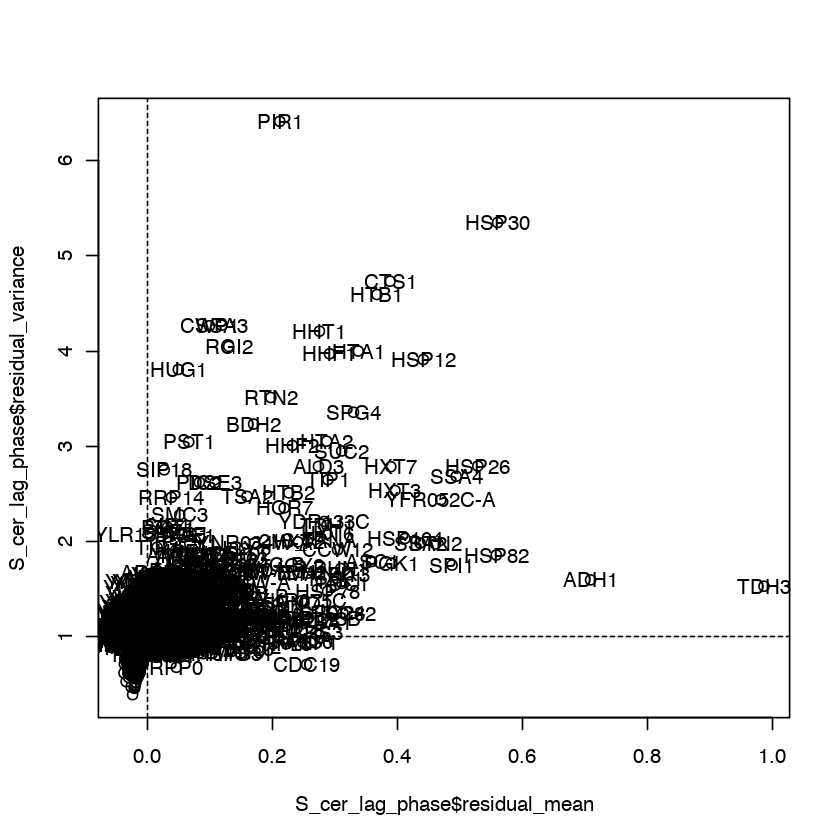

In [24]:
plot(S_cer_lag_phase$residual_mean, S_cer_lag_phase$residual_variance)
abline(v=0, lty=2)
abline(h=1, lty=2)
index_outlier=which(S_cer_lag_phase$residual_mean >0, S_cer_lag_phase$residual_variance > 4)
text(S_cer_lag_phase$residual_mean[index_outlier], S_cer_lag_phase$residual_variance[index_outlier], rownames(S_cer_lag_phase)[index_outlier])

In [25]:
t(t(rownames(S_cer_lag_phase[order(S_cer_lag_phase$residual_variance, decreasing = TRUE),])[1:20]))

PIR1
HSP30
CTS1
HTB1
SSA3
CWP1
HHT1
RGI2
HTA1
HHF1
HSP12


## Comparing lag and log phase (Organisms: S. cer, and S. pombe)

In [26]:
S_cer_log_phase=S_cer_log_phase[match(rownames(S_cer_lag_phase), rownames(S_cer_log_phase)),]

In [27]:
log_ratio=log10(S_cer_log_phase$residual_variance/S_cer_lag_phase$residual_variance)

names(log_ratio)=rownames(S_cer_lag_phase)

In [28]:
t(t(names(sort(log_ratio, decreasing = TRUE)[1:30])))

HO
CWP2
HTA2
PHO11
AHP1
POL30
SSA1
FIT2
CDC19
YCR024C-B
ZRT1


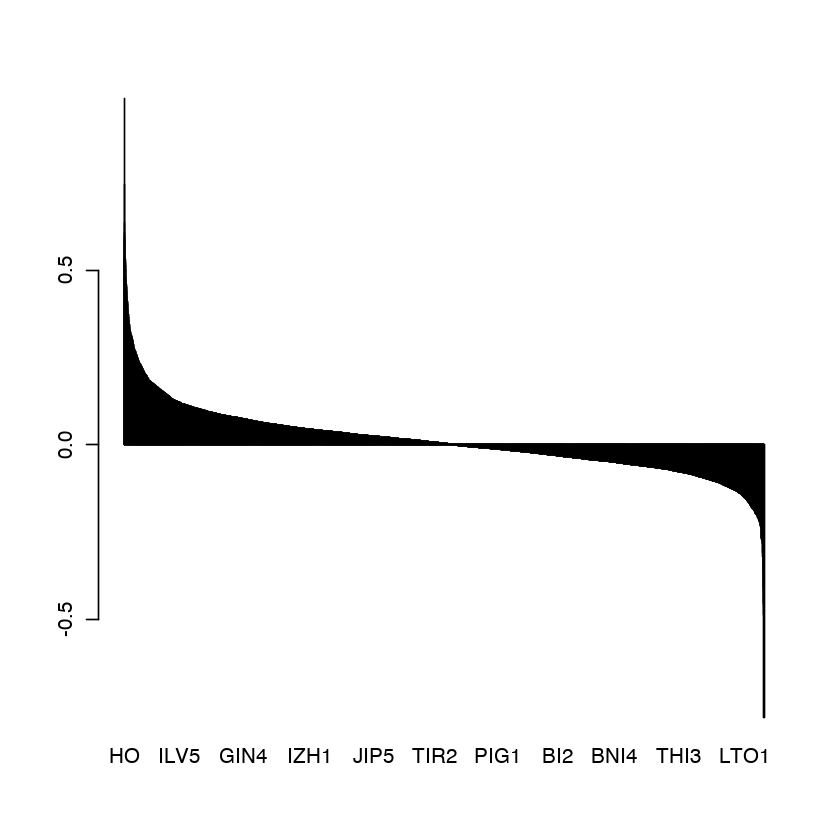

In [30]:
#pdf("barplot_lag_log.pdf")
barplot(sort(log_ratio, decreasing = TRUE), col="gray")
#dev.off()

###  Single-cell RNA-seq (S. pombe, @log phase)

In [32]:
scData=read.csv("../Data/Fission/41564_2018_330_MOESM3_ESM_RAW.csv", row.names = 1)

In [33]:
library("stringr")
#colnames(scData)
first=str_split(colnames(scData), "_", simplify = TRUE)[,1]
second=str_split(colnames(scData), "_", simplify = TRUE)[,2]
#paste(first, second, sep="")
scData=scData[,c(1,which(paste(first, second, sep="")=="X01093"))]

In [34]:
pbmc_data=scData

In [35]:
gene_attr <- data.frame(mean = rowMeans(pbmc_data), detection_rate = rowMeans(pbmc_data > 
    0), var = apply(pbmc_data, 1, var))
gene_attr$log_mean <- log10(gene_attr$mean)
gene_attr$log_var <- log10(gene_attr$var)
rownames(gene_attr) <- rownames(pbmc_data)
cell_attr <- data.frame(n_umi = colSums(pbmc_data), n_gene = colSums(pbmc_data > 
    0))
rownames(cell_attr) <- colnames(pbmc_data)

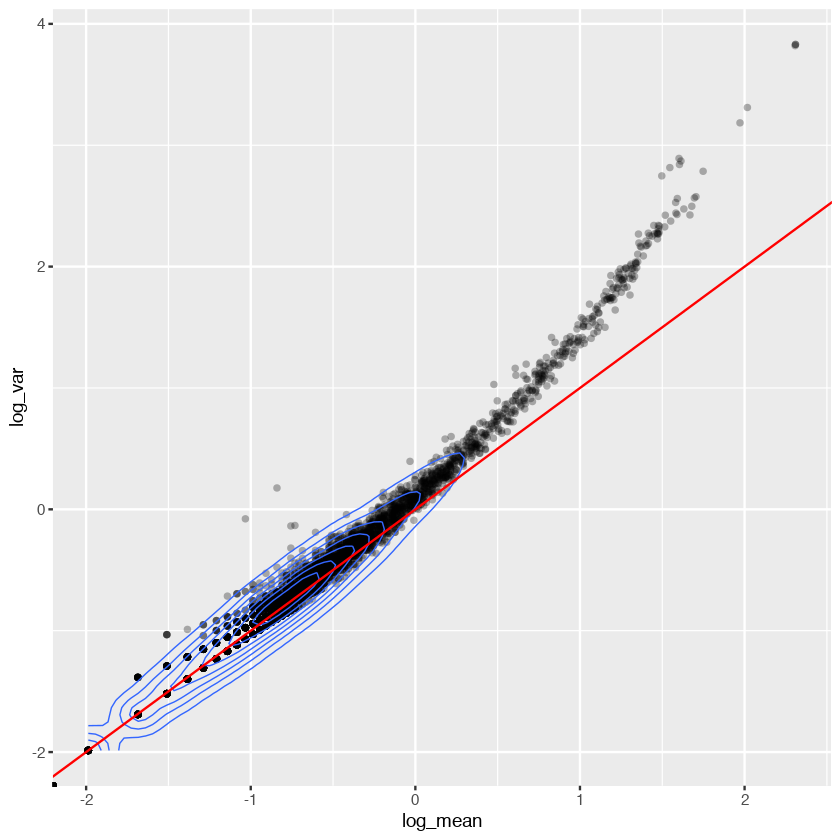

In [36]:
ggplot(gene_attr, aes(log_mean, log_var)) + geom_point(alpha = 0.3, shape = 16) + 
    geom_density_2d(size = 0.3) + geom_abline(intercept = 0, slope = 1, color = "red")

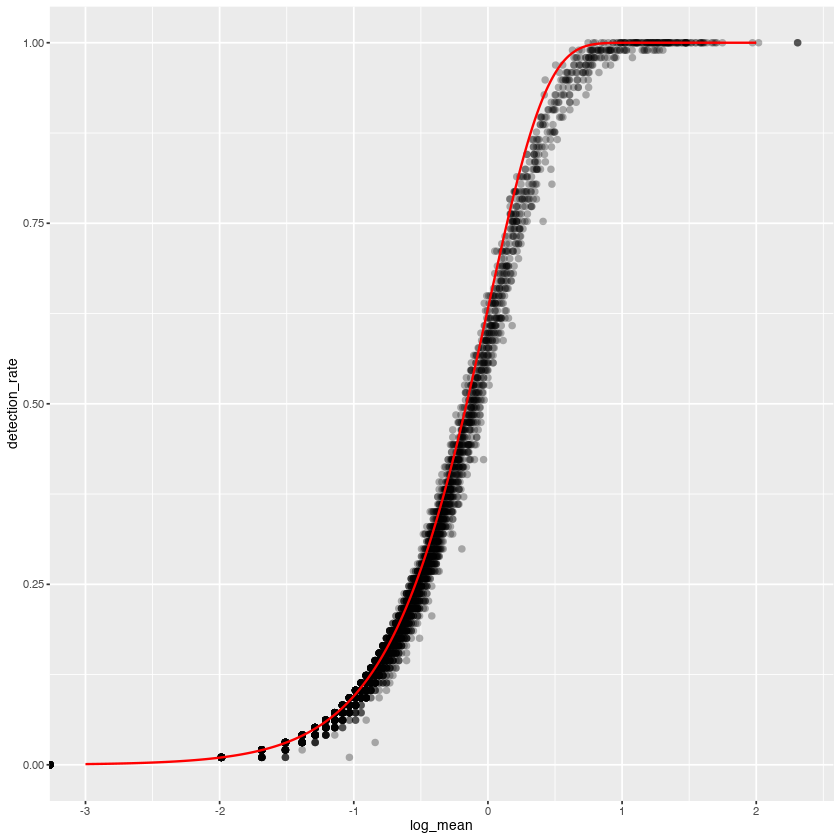

In [37]:
# add the expected detection rate under Poisson model
x = seq(from = -3, to = 2, length.out = 1000)
poisson_model <- data.frame(log_mean = x, detection_rate = 1 - dpois(0, lambda = 10^x))
ggplot(gene_attr, aes(log_mean, detection_rate)) + geom_point(alpha = 0.3, shape = 16) + 
    geom_line(data = poisson_model, color = "red") + theme_gray(base_size = 8)

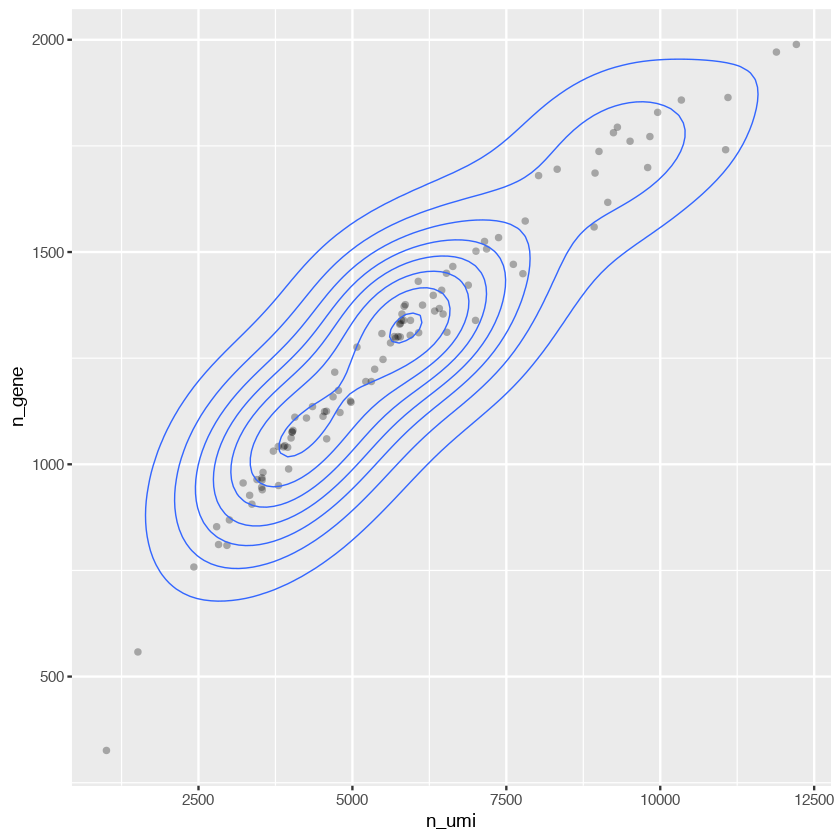

In [38]:
ggplot(cell_attr, aes(n_umi, n_gene)) + geom_point(alpha = 0.3, shape = 16) + geom_density_2d(size = 0.3)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 4486 by 97

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 97 cells

Found 64 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 4486 genes

Calculating gene attributes

Wall clock passed: Time difference of 4.344072 secs



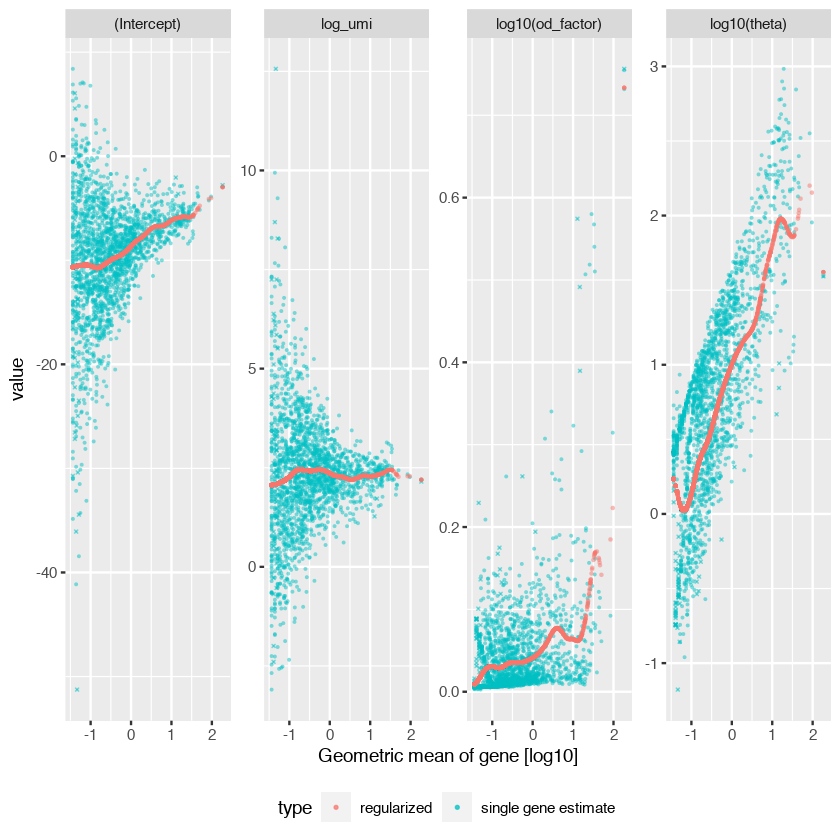

In [39]:
set.seed(44)
pbmc_data=as.matrix(pbmc_data)
vst_out <- sctransform::vst(pbmc_data, latent_var = c("log_umi"), return_gene_attr = TRUE, 
    return_cell_attr = TRUE, verbosity = 1)
#> Calculating cell attributes from input UMI matrix: log_umi
#> Variance stabilizing transformation of count matrix of size 12572 by 2700
#> Model formula is y ~ log_umi
#> Get Negative Binomial regression parameters per gene
#> Using 2000 genes, 2700 cells
#> Found 120 outliers - those will be ignored in fitting/regularization step
#> Second step: Get residuals using fitted parameters for 12572 genes
#> Calculating gene attributes
#> Wall clock passed: Time difference of 17.82073 secs
sctransform::plot_model_pars(vst_out, show_theta = TRUE)

In [40]:
S_pombe_log_phase=vst_out$gene_attr

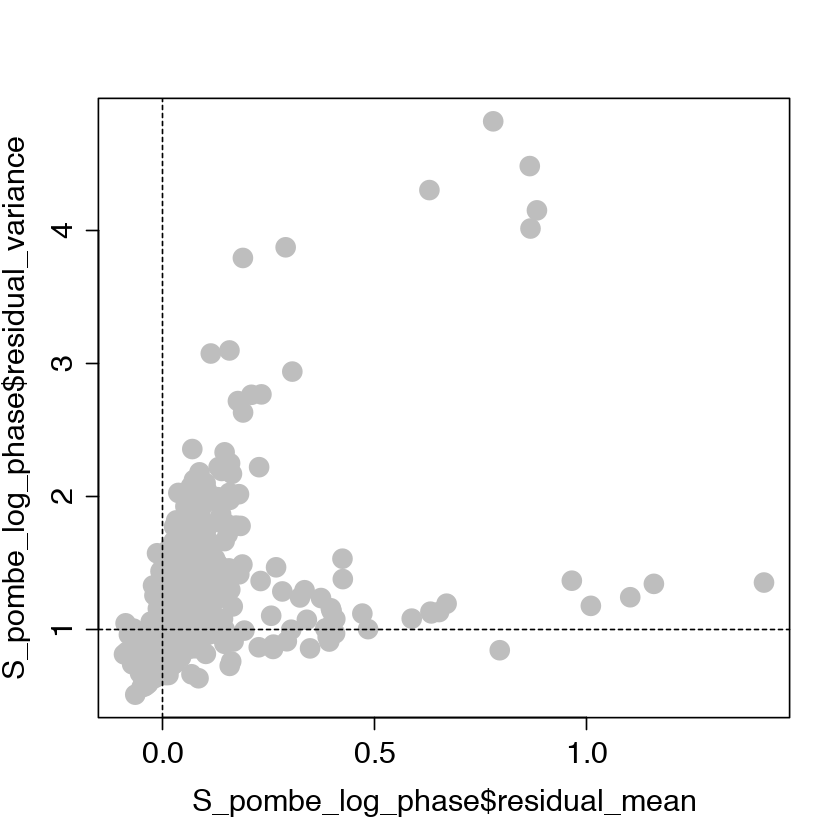

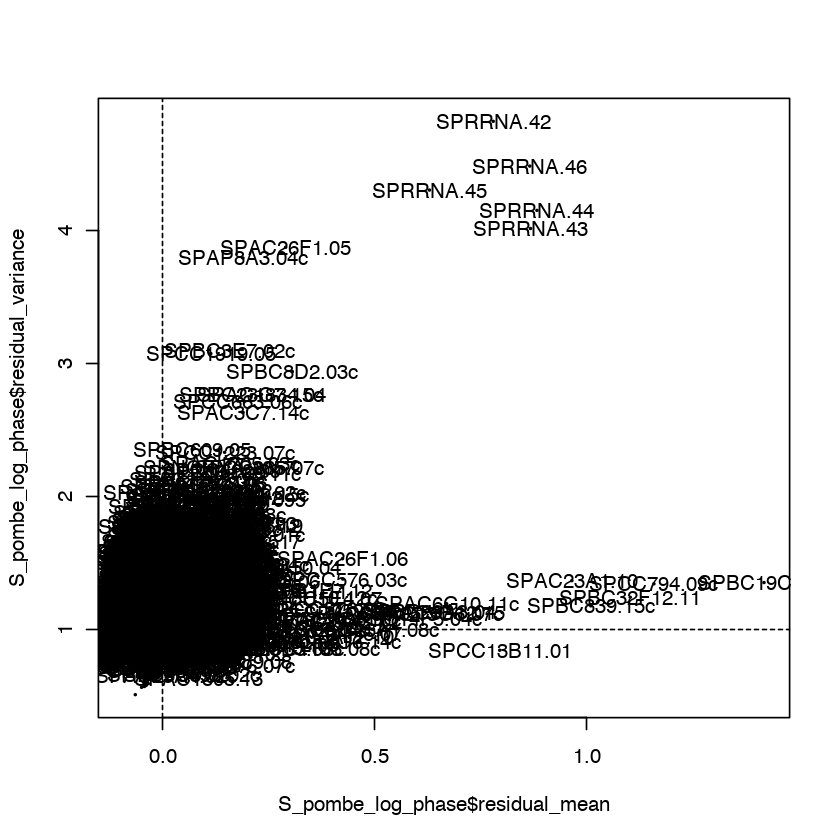

In [41]:
#pdf("stabilized_variance_sPOMBE.pdf")
plot(S_pombe_log_phase$residual_mean, S_pombe_log_phase$residual_variance, cex=2, pch=19, col="gray", cex.lab=1.5, cex.axis=1.5)
abline(v=0, lty=2)
abline(h=1, lty=2)
#dev.off()


#pdf("Stabilized_variance_with_names_Spombe.pdf")
plot(S_pombe_log_phase$residual_mean, S_pombe_log_phase$residual_variance, cex=0.1)
abline(v=0, lty=2)
abline(h=1, lty=2)
index_outlier=which(S_pombe_log_phase$residual_mean >0, S_pombe_log_phase$residual_variance > 4)
text(S_pombe_log_phase$residual_mean[index_outlier], S_pombe_log_phase$residual_variance[index_outlier], rownames(S_pombe_log_phase)[index_outlier])
#dev.off()


In [42]:
t(t(rownames(S_pombe_log_phase[order(S_pombe_log_phase$residual_variance, decreasing = TRUE),])[1:30]))

SPRRNA.42
SPRRNA.46
SPRRNA.45
SPRRNA.44
SPRRNA.43
SPAC26F1.05
SPAP8A3.04c
SPBC3E7.02c
SPCC1919.05
SPBC8D2.03c
SPAC1834.04


#### Do the same orthologs show Cell-to-Cell variability?

In [43]:
S_pombe_genes=rownames(S_pombe_log_phase[order(S_pombe_log_phase$residual_variance, decreasing = TRUE),])
S_cer_genes=rownames(S_cer_log_phase[order(S_cer_log_phase$residual_variance, decreasing = TRUE),])

In [44]:
S_pombe_genes[1:100]
S_cer_genes[1:100]

[1] "SPRRNA.42"     "SPRRNA.46"     "SPRRNA.45"     "SPRRNA.44"    
  [5] "SPRRNA.43"     "SPAC26F1.05"   "SPAP8A3.04c"   "SPBC3E7.02c"  
  [9] "SPCC1919.05"   "SPBC8D2.03c"   "SPAC1834.04"   "SPBC23G7.15c" 
 [13] "SPCC663.06c"   "SPAC3C7.14c"   "SPBC609.05"    "SPCC1223.07c" 
 [17] "SPAC1705.03c"  "SPNCRNA.1057"  "SPCC965.07c"   "SPCC622.09"   
 [21] "SPAC15E1.09"   "SPBC1105.11c"  "SPAC1142.08"   "SPAC17C9.06"  
 [25] "SPAC343.16"    "SPAC644.15"    "SPBC31F10.16"  "SPBC1703.13c" 
 [29] "SPBC1198.02"   "SPCC13B11.02c" "SPACUNK4.12c"  "SPAC4F10.15c" 
 [33] "SPCC16C4.22"   "SPBC1105.12"   "SPAC1565.06c"  "SPBC557.02c"  
 [37] "SPBC16H5.06"   "SPNCRNA.1095"  "SPBC354.10"    "SPAC13D6.01"  
 [41] "SPCC1235.18"   "SPBC3F6.01c"   "SPAC26H5.12"   "SPAC6G9.01c"  
 [45] "SPBPB21E7.04c" "SPBC839.07"    "SPBC211.08c"   "SPNCRNA.1402" 
 [49] "SPBC887.01"    "SPAC24C9.02c"  "SPAC4F8.02c"   "SPCC622.08c"  
 [53] "SPAC6F6.03c"   "SPAC4F10.18"   "SPCC4G3.05c"   "SPAC105.01c"  
 [57] "SPAC13A11.04c" "SPAC823.09c"   "SPAC23A1.14c"  "SPAC30D11.01c"
 [61] "SPAC1782.08c"  "SPAC23C11.17"  "SPAC24C9.09"   "SPAP8A3.02c"  
 [65] "SPBC8D2.15"    "SPCC1235.01"   "SPAC1687.14c"  "SPBC1539.04"  
 [69] "SPCC2H8.05c"   "SPNCRNA.793"   "SPAC23H3.15c"  "SPAC343.15"   
 [73] "SPCC965.06"    "SPBC646.06c"   "SPCC1919.07"   "SPBC21C3.19"  
 [77] "SPAC16A10.04"  "SPBC354.12"    "SPCC126.14"    "SPBC4C3.09"   
 [81] "SPAC926.08c"   "SPCC962.02c"   "SPAC15A10.03c" "SPBC428.12c"  
 [85] "SPAC2E1P5.05"  "SPMIT.06"      "SPACUNK4.06c"  "SPBC15C4.03"  
 [89] "SPAC1F8.02c"   "SPBC839.10"    "SPBC354.07c"   "SPNCRNA.1515" 
 [93] "SPBC1734.05c"  "SPCC18.13"     "SPCC594.01"    "SPBC19G7.19"  
 [97] "SPAC2F7.16c"   "SPAC16.03c"    "SPBC17D11.02c" "SPBC4.03c"

[1] "HTA2"      "HO"        "HHT1"      "HHF1"      "CTS1"      "HTA1"     
  [7] "PST1"      "HTB1"      "CWP2"      "HUG1"      "HHF2"      "HSP12"    
 [13] "HTB2"      "PHO11"     "ZRT1"      "RPS26A"    "YCR024C-B" "POL30"    
 [19] "PDC1"      "ARG3"      "ALD3"      "HOR7"      "HSP82"     "CCW12"    
 [25] "FIT2"      "SSA1"      "HHT2"      "YGP1"      "ADH1"      "ARG1"     
 [31] "AHP1"      "TDH1"      "PSA1"      "RPL31A"    "PIR1"      "MSC1"     
 [37] "NCE102"    "TIP1"      "SPI1"      "DSE4"      "CWP1"      "SNZ1"     
 [43] "AIM44"     "NQM1"      "FIT3"      "HXT2"      "HXT3"      "PGM2"     
 [49] "RTN2"      "ALD6"      "SHM2"      "BAR1"      "CIS3"      "GPH1"     
 [55] "RPL29"     "SSA3"      "FBA1"      "PHO3"      "PHO84"     "GPX2"     
 [61] "GLN1"      "HPF1"      "PBI1"      "POR1"      "PHO5"      "SOL4"     
 [67] "OLE1"      "CDC19"     "PRY1"      "MET17"     "PNC1"      "PCL9"     
 [73] "21S_rRNA"  "SVS1"      "MTC7"      "NCE103"    "TMA10"     "SSA2"     
 [79] "ENO1"      "YLR460C"   "HSP26"     "EGT2"      "YLR194C"   "TSA2"     
 [85] "TIR1"      "BTN2"      "YLR257W"   "HMX1"      "PAU15"     "HXT7"     
 [91] "ERG3"      "GAD1"      "YGL039W"   "PGA1"      "CPA2"      "TDH2"     
 [97] "RNR4"      "CHS1"      "YLR227W-B" "RPS3"

In [45]:
Spombe_Scer_orts=read.csv("Spombe_Scer.csv")

In [46]:
Convert=read.csv("orftogene_36773464.csv", sep="\t", header = FALSE)
Convert=Convert[,-1]
colnames(Convert)=c("ORF", "Gene_name", "Gene_info")
Convert=as.data.frame(Convert)
write.csv(Convert, "Yeast_orf_genename.csv")

In [47]:
Convert

ORF,Gene_name,Gene_info
<fct>,<fct>,<fct>
YAL001C,TFC3,Largest of six subunits of the RNA polymerase III transcription initiation factor complex (TFIIIC); part of the TauB domain of TFIIIC that binds DNA at the BoxB promoter sites of tRNA and similar genes; cooperates with Tfc6p in DNA binding
YAL002W,VPS8,Membrane-associated protein that interacts with Vps21p to facilitate soluble vacuolar protein localization; component of the CORVET complex; required for localization and trafficking of the CPY sorting receptor; contains RING finger motif
YAL003W,EFB1,"Translation elongation factor 1 beta; stimulates nucleotide exchange to regenerate EF-1 alpha-GTP for the next elongation cycle; part of the EF-1 complex, which facilitates binding of aminoacyl-tRNA to the ribosomal A site"
YAL005C,SSA1,"ATPase involved in protein folding and nuclear localization signal (NLS)-directed nuclear transport; member of heat shock protein 70 (HSP70) family; forms a chaperone complex with Ydj1p; localized to the nucleus, cytoplasm, and cell wall; 98% identical with Ssa2p, but subtle differences between the two proteins provide functional specificity with respect to propagation of yeast [URE3] prions and vacuolar-mediated degradations of gluconeogenesis enzymes"
YAL007C,ERP2,"Protein that forms a heterotrimeric complex with Erp1p, Emp24p, and Erv25p; member, along with Emp24p and Erv25p, of the p24 family involved in ER to Golgi transport and localized to COPII-coated vesicles"
YAL008W,FUN14,Mitochondrial protein of unknown function
YAL009W,SPO7,"Putative regulatory subunit of Nem1p-Spo7p phosphatase holoenzyme, regulates nuclear growth by controlling phospholipid biosynthesis, required for normal nuclear envelope morphology, premeiotic replication, and sporulation"
YAL010C,MDM10,"Subunit of both the ERMES complex that links the ER to mitochondria, and of the mitochondrial sorting and assembly machinery (SAM complex) that functions in import and assembly of outer membrane beta-barrel proteins"
YAL011W,SWC3,"Protein of unknown function, component of the SWR1 complex, which exchanges histone variant H2AZ (Htz1p) for chromatin-bound histone H2A; required for formation of nuclear-associated array of smooth endoplasmic reticulum known as karmellae"


In [48]:
S_cer_genes=Convert$ORF[match(S_cer_genes, Convert$ORF)]

In [49]:
S_cer_genes_orf=S_cer_genes[which(S_cer_genes!= "<NA>")]

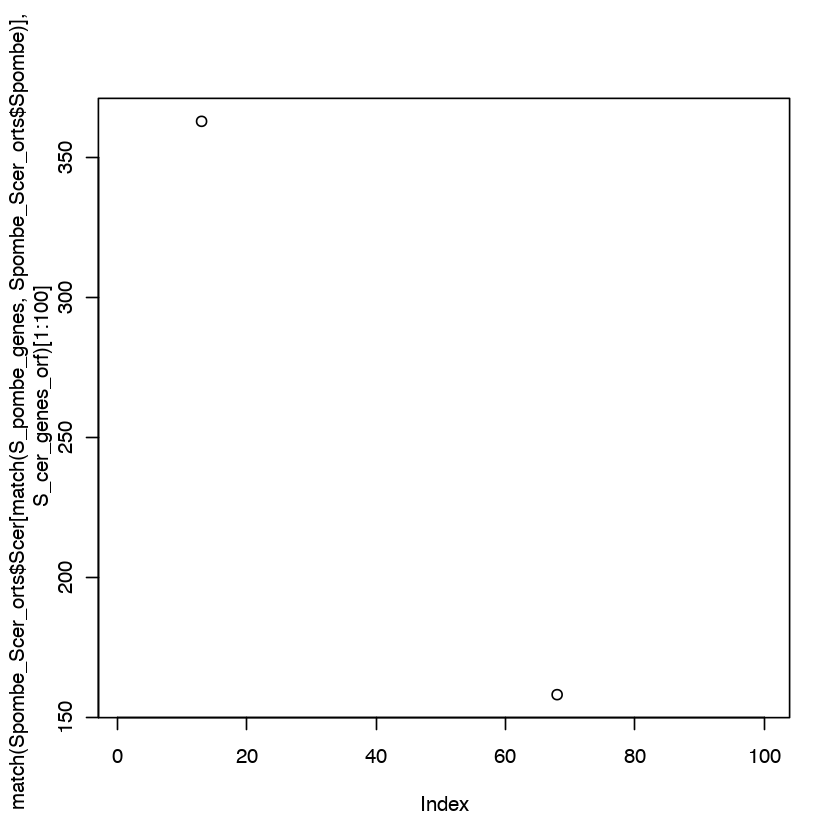

In [50]:
plot(match(Spombe_Scer_orts$Scer[match(S_pombe_genes, Spombe_Scer_orts$Spombe)], S_cer_genes_orf)[1:100], type="b")

### Using Interspecie proteomics to compare the significance of findings using single-cell RNA-seq

In [52]:
Proteone_abundance=read.csv("Protepmics_interspecie.csv")

In [53]:
index_top10=match(paste(S_cer_genes[1:10],"P", sep=""), toupper(Proteone_abundance$Gene_name))

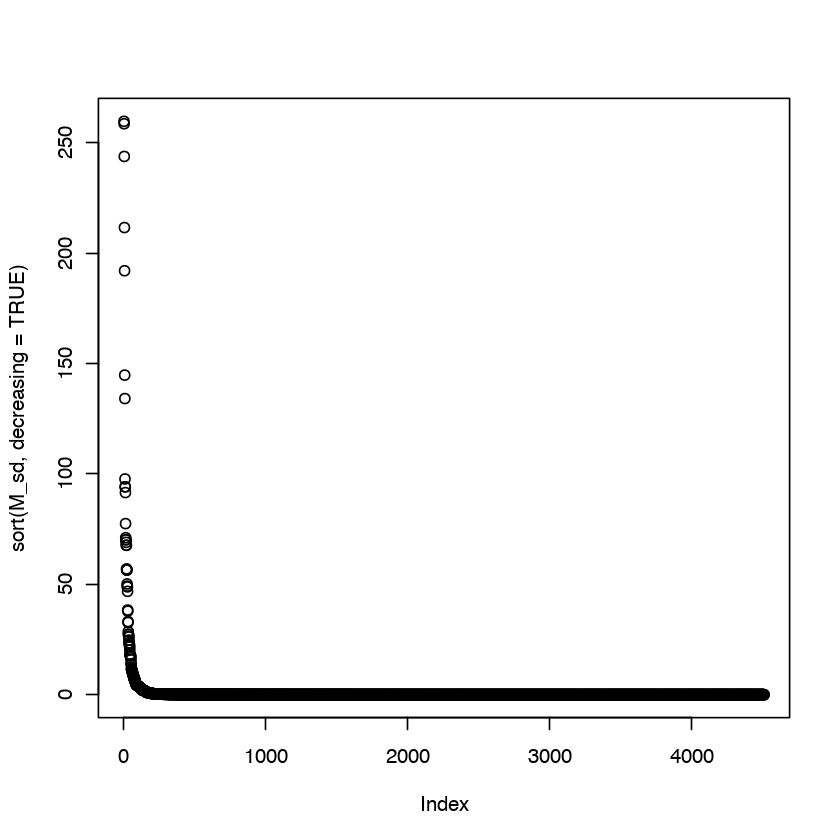

In [54]:
M=Proteone_abundance[,6:13]
M_sd=apply(M, 1, var)

M_mean=rowMeans(M, na.rm = TRUE)
plot(sort(M_sd, decreasing = TRUE))
abline(h=M_sd[index_top10])


	Pearson's product-moment correlation

data:  S_cer_log_phase$residual_variance and M_sd[index]
t = 6.8542, df = 4109, p-value = 8.238e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.07599851 0.13644829
sample estimates:
      cor 
0.1063216 


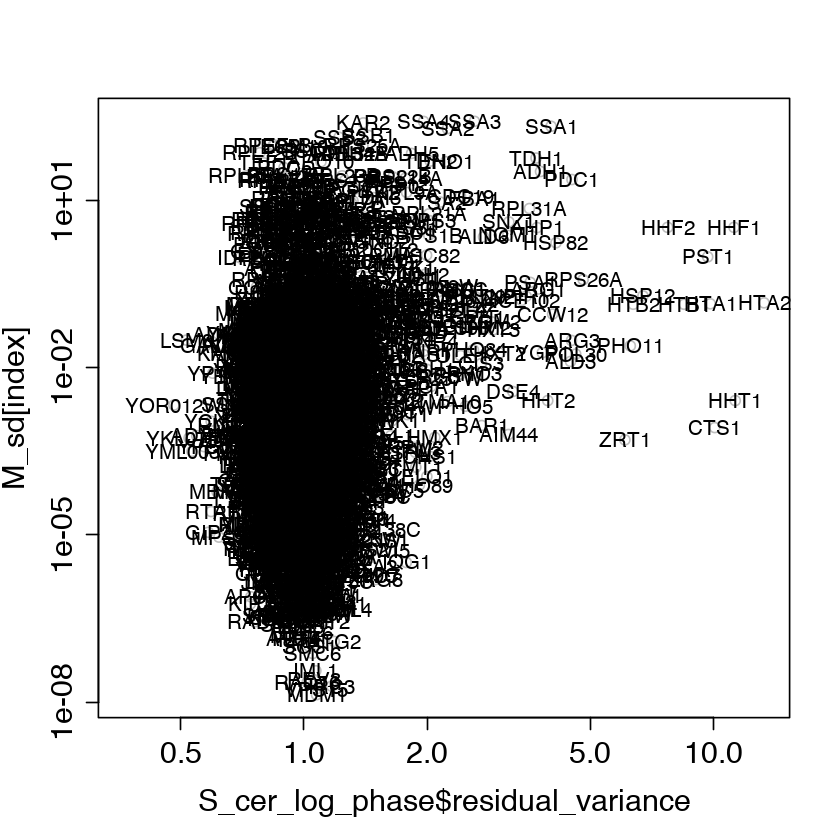

In [56]:
#pdf("Proteomic_interspecie_scRNA.pdf")
index=match(paste(rownames(S_cer_log_phase),"P", sep=""),toupper(Proteone_abundance$Gene_name))
plot(S_cer_log_phase$residual_variance, M_sd[index], log="xy", col="gray", cex.axis=1.5, cex.lab=1.5)
text(S_cer_log_phase$residual_variance, M_sd[index], rownames(S_cer_log_phase))

cor.test(S_cer_log_phase$residual_variance, M_sd[index])
#dev.off()

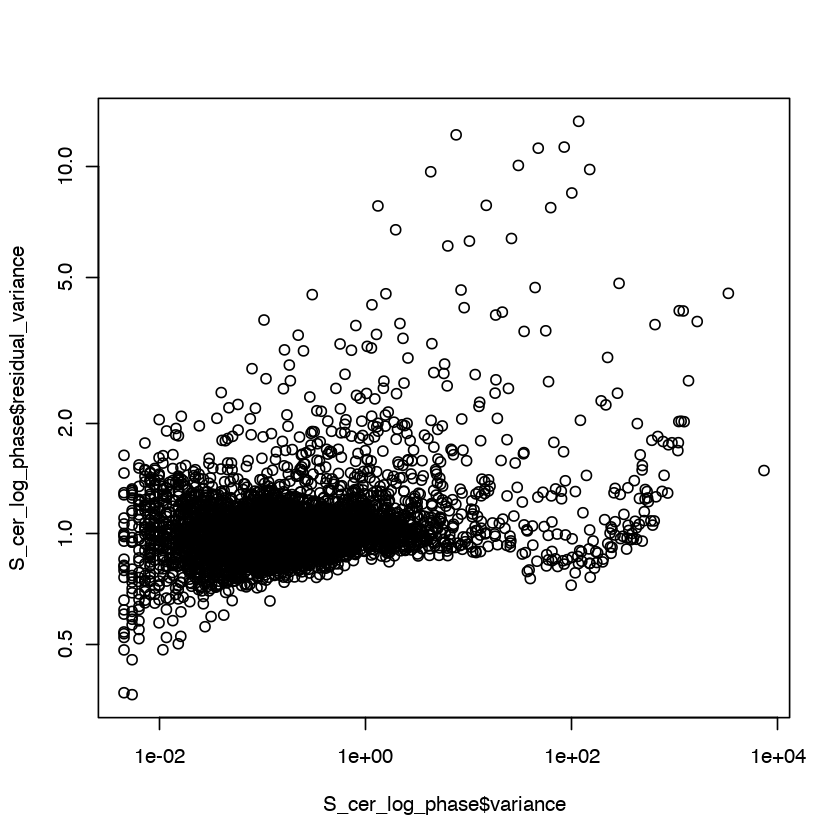

In [57]:
plot(S_cer_log_phase$variance, S_cer_log_phase$residual_variance, log="xy")

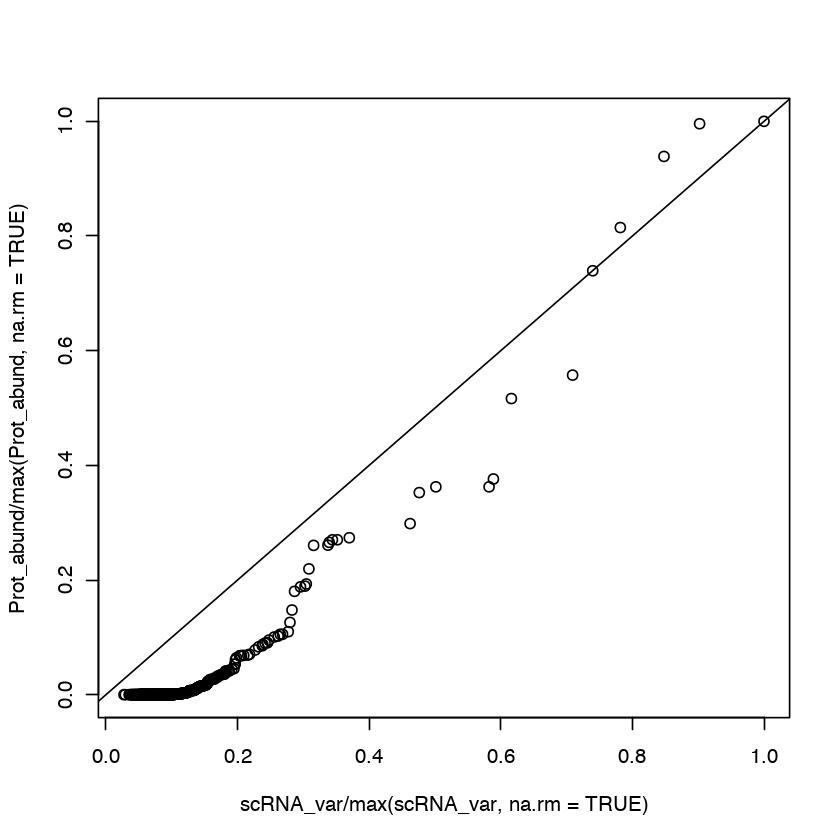

In [58]:
scRNA_var=S_cer_log_phase$residual_variance
Prot_abund=M_sd[index]

qqplot(scRNA_var/max(scRNA_var, na.rm = TRUE), Prot_abund/max(Prot_abund, na.rm = TRUE))
abline(a=0, b=1)